In [39]:
# Install required dependencies
# !pip install numpy scikit-learn imutils joblib
# !pip install ultralytics supervision pillow mediapipe --trusted-host pypi.org --trusted-host files.pythonhosted.org --default-timeout=100

In [40]:
# !pip install --upgrade pip
# !pip install mediapipe==0.10.9 ultralytics supervision --no-cache-dir

In [41]:
# pip install tensorflow

In [42]:
# !pip install --upgrade numpy

In [43]:
from huggingface_hub import hf_hub_download
from ultralytics import YOLO
from supervision import Detections
from PIL import Image
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
import concurrent.futures
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import DepthwiseConv2D
from tensorflow.keras import layers

In [44]:
# --- Load YOLO model ---
model_path = hf_hub_download(repo_id="arnabdhar/YOLOv8-Face-Detection", filename="model.pt")
yolo_model = YOLO(model_path)

In [45]:
# --- Load Mediapipe face mesh ---
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(refine_landmarks=True)

In [46]:
# --- Load Drowsiness Detection Model ---
class CustomDepthwiseConv2D(layers.DepthwiseConv2D):
    def __init__(self, *args, **kwargs):
        kwargs.pop('groups', None)
        super().__init__(*args, **kwargs)

In [47]:
# from tensorflow.keras.layers import InputLayer as OriginalInputLayer

# class CustomInputLayer(OriginalInputLayer):
#     @classmethod
#     def from_config(cls, config):
#         # Convert 'batch_shape' to 'batch_input_shape' if present
#         if 'batch_shape' in config:
#             config['batch_input_shape'] = config.pop('batch_shape')
#         return super().from_config(config)


In [48]:
# import os
# print(os.listdir())

In [49]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [50]:
# !pip install --upgrade tensorflow

In [51]:
# from google.colab import drive
# drive.mount('/content/drive')

In [52]:
custom_objects = {'DepthwiseConv2D': CustomDepthwiseConv2D}
model_path = 'last_trained_model_after_freeze(for new dataset_96.99%).h5'
drowsiness_model = load_model(model_path, custom_objects=custom_objects)

In [179]:
# --- Load image ---
image_path = "grad project/test3.jfif"
image = Image.open(image_path)
image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

In [180]:
# --- Detect face using YOLO ---
output = yolo_model(image)
results = Detections.from_ultralytics(output[0])

if len(results.xyxy) == 0:
    print("No face detected!")
    exit()


0: 640x448 1 FACE, 86.0ms
Speed: 11.6ms preprocess, 86.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


In [181]:
# Extract bounding box and crop face
x_min, y_min, x_max, y_max = map(int, results.xyxy[0])
cropped_face = image_cv[y_min:y_max, x_min:x_max]

In [182]:
# --- Detect landmarks using Mediapipe ---
image_rgb = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)
results = face_mesh.process(image_rgb)

if not results.multi_face_landmarks:
    print("No landmarks detected!")
    exit()

face_landmarks = results.multi_face_landmarks[0]

In [183]:
# Convert landmarks to numpy array
height, width, _ = cropped_face.shape
landmarks = np.array([(int(pt.x * width), int(pt.y * height)) for pt in face_landmarks.landmark])

In [184]:
# Extract left and right eye landmarks
left_eye_idx = [33, 160, 158, 133, 153, 144]  # Indices for left eye
right_eye_idx = [362, 385, 387, 263, 373, 380]  # Indices for right eye
left_eye_pts = landmarks[left_eye_idx]
right_eye_pts = landmarks[right_eye_idx]

In [185]:
# Crop eyes
margin = 10
lx, ly, lw, lh = cv2.boundingRect(left_eye_pts)
left_eye = cropped_face[max(ly - margin, 0):ly + lh + margin, max(lx - margin, 0):lx + lw + margin]

rx, ry, rw, rh = cv2.boundingRect(right_eye_pts)
right_eye = cropped_face[max(ry - margin, 0):ry + rh + margin, max(rx - margin, 0):rx + rw + margin]

In [186]:
# Extract mouth landmarks
mouth_idx = list(range(78, 88)) + list(range(308, 318))  # Outer lips
mouth_pts = landmarks[mouth_idx]

# Crop mouth
mx, my, mw, mh = cv2.boundingRect(mouth_pts)
mouth_crop = cropped_face[max(my - margin, 0):my + mh + margin, max(mx - margin, 0):mx + mw + margin]


In [187]:
# --- Preprocessing for model ---
def preprocess_image(img):
    img_resized = cv2.resize(img, (299, 299)) / 255.0
    return np.expand_dims(img_resized, axis=0)

In [188]:
# Process mouth, left eye, right eye in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    future_mouth = executor.submit(preprocess_image, mouth_crop)
    future_left_eye = executor.submit(preprocess_image, left_eye)
    future_right_eye = executor.submit(preprocess_image, right_eye)

    mouth_input = future_mouth.result()
    left_eye_input = future_left_eye.result()
    right_eye_input = future_right_eye.result()

In [189]:
# --- Get model predictions ---
mouth_probs = drowsiness_model.predict(mouth_input)[0]  # For yawning
mouth_pred = np.array([mouth_probs[1], mouth_probs[3]]).argmax()

left_eye_probs = drowsiness_model.predict(left_eye_input)[0]  # Get probability array
left_eye_pred = np.array([left_eye_probs[0], left_eye_probs[2]]).argmax()  # Get max from classes 0 & 1

right_eye_probs = drowsiness_model.predict(right_eye_input)[0]  # Get probability array
right_eye_pred = np.array([right_eye_probs[0], right_eye_probs[2]]).argmax()  # Get max from classes 0 & 1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


In [190]:
print(left_eye_pred)

0


In [191]:
# --- Determine drowsiness status ---
status = "Awake"
if left_eye_pred == 0 and right_eye_pred == 0:
    status = "Drowsy"
if mouth_pred  == 1:
    status = "Yawning"
if left_eye_pred == 0 and right_eye_pred == 0 and mouth_pred  == 1:
    status = "Drowsy and Yawning"

In [192]:
# --- Visualization ---
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

(-0.5, 485.5, 687.5, -0.5)

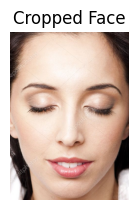

In [193]:
# Plot cropped face
plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
plt.title("Cropped Face")
plt.axis("off")

(-0.5, 132.5, 31.5, -0.5)

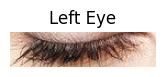

In [194]:
# Plot left eye
plt.subplot(2, 3, 2)
plt.imshow(cv2.cvtColor(left_eye, cv2.COLOR_BGR2RGB))
plt.title("Left Eye")
plt.axis("off")

(-0.5, 125.5, 35.5, -0.5)

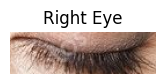

In [195]:
# Plot right eye
plt.subplot(2, 3, 3)
plt.imshow(cv2.cvtColor(right_eye, cv2.COLOR_BGR2RGB))
plt.title("Right Eye")
plt.axis("off")

(-0.5, 485.5, 687.5, -0.5)

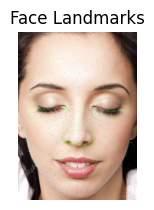

In [196]:
# Plot landmarks on cropped face
landmarked_face = cropped_face.copy()
for (x, y) in landmarks:
    cv2.circle(landmarked_face, (x, y), 1, (0, 255, 0), -1)

plt.subplot(2, 3, 4)
plt.imshow(cv2.cvtColor(landmarked_face, cv2.COLOR_BGR2RGB))
plt.title("Face Landmarks")
plt.axis("off")

(-0.5, 132.5, 31.5, -0.5)

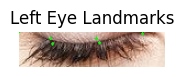

In [197]:
# Plot landmarks on left eye
landmarked_left_eye = left_eye.copy()
for (x, y) in left_eye_pts:
    cv2.circle(landmarked_left_eye, (x - lx, y - ly), 1, (0, 255, 0), -1)

plt.subplot(2, 3, 5)
plt.imshow(cv2.cvtColor(landmarked_left_eye, cv2.COLOR_BGR2RGB))
plt.title("Left Eye Landmarks")
plt.axis("off")

(-0.5, 125.5, 35.5, -0.5)

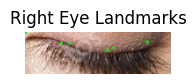

In [198]:
# Plot landmarks on right eye
landmarked_right_eye = right_eye.copy()
for (x, y) in right_eye_pts:
    cv2.circle(landmarked_right_eye, (x - rx, y - ry), 1, (0, 255, 0), -1)

plt.subplot(2, 3, 6)
plt.imshow(cv2.cvtColor(landmarked_right_eye, cv2.COLOR_BGR2RGB))
plt.title("Right Eye Landmarks")
plt.axis("off")

In [199]:
print(f"Final Prediction: {status}")

Final Prediction: Drowsy


In [206]:
# import torch 
# print(torch.cuda.is_available())

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
from supervision import Detections
from huggingface_hub import hf_hub_download
from PIL import Image
import mediapipe as mp
import concurrent.futures
from tensorflow.keras.models import load_model
from tensorflow.keras import layers

# --- Class mapping ---
class_labels = {
    0: "Closed_Eyes",
    1: "No_yawn",
    2: "Open_Eyes",
    3: "Yawning"
}

print("Class Index Mapping:")
for idx, name in class_labels.items():
    print(f"{idx}: {name}")

# --- Load YOLOv8 model for face detection ---
model_path = hf_hub_download(repo_id="arnabdhar/YOLOv8-Face-Detection", filename="model.pt")
yolo_model = YOLO(model_path)

# --- Load Mediapipe face mesh ---
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(refine_landmarks=True)

# --- Load custom CNN model with DepthwiseConv2D ---
class CustomDepthwiseConv2D(layers.DepthwiseConv2D):
    def __init__(self, *args, **kwargs):
        kwargs.pop('groups', None)
        super().__init__(*args, **kwargs)

custom_objects = {'DepthwiseConv2D': CustomDepthwiseConv2D}
model_path = 'last_trained_model_after_freeze(for new dataset_96.99%).h5'
drowsiness_model = load_model(model_path, custom_objects=custom_objects)

# --- Preprocessing function ---
def preprocess_image(img):
    img_resized = cv2.resize(img, (299, 299)) / 255.0
    return np.expand_dims(img_resized, axis=0)

# --- Start webcam ---
cap = cv2.VideoCapture(0)
margin = 10

while True:
    ret, frame = cap.read()
    if not ret:
        break

    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(image_rgb)

    # Detect face
    output = yolo_model(image_pil)
    results = Detections.from_ultralytics(output[0])

    if len(results.xyxy) == 0:
        cv2.putText(frame, "No face detected", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 0, 255), 2)
        cv2.imshow("Drowsiness Detection", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        continue

    x_min, y_min, x_max, y_max = map(int, results.xyxy[0])
    cropped_face = frame[y_min:y_max, x_min:x_max]
    face_rgb = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)
    mp_result = face_mesh.process(face_rgb)

    if not mp_result.multi_face_landmarks:
        cv2.putText(frame, "No landmarks", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 0, 255), 2)
        cv2.imshow("Drowsiness Detection", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        continue

    face_landmarks = mp_result.multi_face_landmarks[0]
    height, width, _ = cropped_face.shape
    landmarks = np.array([(int(pt.x * width), int(pt.y * height)) for pt in face_landmarks.landmark])

    # Indices
    left_eye_idx = [33, 160, 158, 133, 153, 144]
    right_eye_idx = [362, 385, 387, 263, 373, 380]
    mouth_idx = list(range(78, 88)) + list(range(308, 318))

    # Get points
    left_eye_pts = landmarks[left_eye_idx]
    right_eye_pts = landmarks[right_eye_idx]
    mouth_pts = landmarks[mouth_idx]

    # Crop eyes and mouth
    lx, ly, lw, lh = cv2.boundingRect(left_eye_pts)
    rx, ry, rw, rh = cv2.boundingRect(right_eye_pts)
    mx, my, mw, mh = cv2.boundingRect(mouth_pts)

    left_eye = cropped_face[max(ly - margin, 0):ly + lh + margin, max(lx - margin, 0):lx + lw + margin]
    right_eye = cropped_face[max(ry - margin, 0):ry + rh + margin, max(rx - margin, 0):rx + rw + margin]
    mouth_crop = cropped_face[max(my - margin, 0):my + mh + margin, max(mx - margin, 0):mx + mw + margin]

    try:
        # Preprocess
        with concurrent.futures.ThreadPoolExecutor() as executor:
            f_mouth = executor.submit(preprocess_image, mouth_crop)
            f_left = executor.submit(preprocess_image, left_eye)
            f_right = executor.submit(preprocess_image, right_eye)

            mouth_input = f_mouth.result()
            left_input = f_left.result()
            right_input = f_right.result()

        # Predict
        mouth_probs = drowsiness_model.predict(mouth_input, verbose=0)[0]
        left_probs = drowsiness_model.predict(left_input, verbose=0)[0]
        right_probs = drowsiness_model.predict(right_input, verbose=0)[0]

        # Map predictions
        mouth_pred = np.array([mouth_probs[1], mouth_probs[3]]).argmax()
        left_eye_pred = np.array([left_probs[0], left_probs[2]]).argmax()
        right_eye_pred = np.array([right_probs[0], right_probs[2]]).argmax()

        # --- Determine drowsiness status ---
        status = "Awake"
        if left_eye_pred == 0 and right_eye_pred == 0:
            status = "Drowsy"
        if mouth_pred  == 1:
            status = "Yawning"
        if left_eye_pred == 0 and right_eye_pred == 0 and mouth_pred  == 1:
            status = "Drowsy and Yawning"

        # Draw status
        cv2.putText(frame, f"Status: {status}", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 255, 0), 3)

    except Exception as e:
        cv2.putText(frame, f"Error: {str(e)}", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    cv2.imshow("Drowsiness Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Class Index Mapping:
0: Closed_Eyes
1: No_yawn
2: Open_Eyes
3: Yawning


INFO:tensorflow:Assets written to: C:\Users\amrka\AppData\Local\Temp\tmpi3tack6z\assets


INFO:tensorflow:Assets written to: C:\Users\amrka\AppData\Local\Temp\tmpi3tack6z\assets


Saved artifact at 'C:\Users\amrka\AppData\Local\Temp\tmpi3tack6z'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  1807101484240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1807101485200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1807101484624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1807101484048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1807101484432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1807101486352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1807101483088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1807101477520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1807101480784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1807101482896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  180710

In [1]:
import tensorflow as tf
from tensorflow.keras import layers

# --- Custom Layer used in your model ---
class CustomDepthwiseConv2D(layers.DepthwiseConv2D):
    def __init__(self, *args, **kwargs):
        kwargs.pop('groups', None)
        super().__init__(*args, **kwargs)

# --- Load the Keras .h5 model ---
model = tf.keras.models.load_model(
    "last_trained_model_after_freeze(for new dataset_96.99%).h5",
    custom_objects={"DepthwiseConv2D": CustomDepthwiseConv2D}
)

# --- Convert to TFLite ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optional for size/speed
tflite_model = converter.convert()

# --- Save as .tflite file ---
with open("drowsiness_model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Model converted successfully: drowsiness_model.tflite")


INFO:tensorflow:Assets written to: C:\Users\amrka\AppData\Local\Temp\tmp9u31f2m9\assets


INFO:tensorflow:Assets written to: C:\Users\amrka\AppData\Local\Temp\tmp9u31f2m9\assets


Saved artifact at 'C:\Users\amrka\AppData\Local\Temp\tmp9u31f2m9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2366845923216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2366845924560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2366845923984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2366845923408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2366845923600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2366845923792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2366845925712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2366845924176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2366845926096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2366845926864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  236684

In [2]:
# --- Load the Keras .h5 model ---
face_model = tf.keras.models.load_model(
    "final_inceptionv3_2class_sunglasses(accuracy 97.33%).h5",
    custom_objects={"DepthwiseConv2D": CustomDepthwiseConv2D}
)

# --- Convert to TFLite ---
converter = tf.lite.TFLiteConverter.from_keras_model(face_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optional for size/speed
face_type_tflite  = converter.convert()

# --- Save as .tflite file ---
with open("face_type_model.tflite", "wb") as f:
    f.write(face_type_tflite )

print("✅ Model converted successfully: face_type_model.tflite")

INFO:tensorflow:Assets written to: C:\Users\amrka\AppData\Local\Temp\tmpoz29epnb\assets


INFO:tensorflow:Assets written to: C:\Users\amrka\AppData\Local\Temp\tmpoz29epnb\assets


Saved artifact at 'C:\Users\amrka\AppData\Local\Temp\tmpoz29epnb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2366958891856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2366958892240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2367253233936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2366958890896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2367253235280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2367253234128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2367253235664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2367253235856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2367253236816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2367253234896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  236725

Lite model without threads

In [25]:
import cv2
import numpy as np
from ultralytics import YOLO
from supervision import Detections
from huggingface_hub import hf_hub_download
from PIL import Image
import mediapipe as mp
import tensorflow as tf
import time

# --- Class index map ---
class_labels = {
    0: "Closed_Eyes",
    1: "No_yawn",
    2: "Open_Eyes",
    3: "Yawning"
}

# --- Load YOLOv8 face detector ---
model_path = hf_hub_download(repo_id="arnabdhar/YOLOv8-Face-Detection", filename="model.pt")
yolo_model = YOLO(model_path)

# --- Load Mediapipe face mesh ---
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(refine_landmarks=True)

# --- Load TFLite model ---
interpreter = tf.lite.Interpreter(model_path="drowsiness_model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# --- TFLite predict function ---
def tflite_predict(image_input):
    interpreter.set_tensor(input_details[0]['index'], image_input.astype(np.float32))
    interpreter.invoke()
    return interpreter.get_tensor(output_details[0]['index'])[0]

# --- Preprocess image to (160x160) and normalize ---
def preprocess_image(img):
    img_resized = cv2.resize(img, (299, 299)) / 255.0
    return np.expand_dims(img_resized, axis=0)

# --- Start webcam ---
cap = cv2.VideoCapture(0)
margin = 10

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.resize(frame, (640, 480))
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(image_rgb)

    # --- YOLO Face Detection ---
    output = yolo_model(image_pil)
    results = Detections.from_ultralytics(output[0])

    if len(results.xyxy) == 0:
        cv2.putText(frame, "No face detected", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.imshow("Drowsiness Detection", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        continue

    # Get face box and crop
    x_min, y_min, x_max, y_max = map(int, results.xyxy[0])
    cropped_face = frame[y_min:y_max, x_min:x_max]
    face_rgb = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)
    mp_result = face_mesh.process(face_rgb)

    if not mp_result.multi_face_landmarks:
        cv2.putText(frame, "No landmarks", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.imshow("Drowsiness Detection", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        continue

    # Extract facial landmarks
    face_landmarks = mp_result.multi_face_landmarks[0]
    height, width, _ = cropped_face.shape
    landmarks = np.array([(int(pt.x * width), int(pt.y * height)) for pt in face_landmarks.landmark])

    # Indices for regions
    left_eye_idx = [33, 160, 158, 133, 153, 144]
    right_eye_idx = [362, 385, 387, 263, 373, 380]
    mouth_idx = list(range(78, 88)) + list(range(308, 318))

    left_eye_pts = landmarks[left_eye_idx]
    right_eye_pts = landmarks[right_eye_idx]
    mouth_pts = landmarks[mouth_idx]

    lx, ly, lw, lh = cv2.boundingRect(left_eye_pts)
    rx, ry, rw, rh = cv2.boundingRect(right_eye_pts)
    mx, my, mw, mh = cv2.boundingRect(mouth_pts)

    left_eye = cropped_face[max(ly - margin, 0):ly + lh + margin, max(lx - margin, 0):lx + lw + margin]
    right_eye = cropped_face[max(ry - margin, 0):ry + rh + margin, max(rx - margin, 0):rx + rw + margin]
    mouth_crop = cropped_face[max(my - margin, 0):my + mh + margin, max(mx - margin, 0):mx + mw + margin]

    try:
        left_input = preprocess_image(left_eye)
        right_input = preprocess_image(right_eye)
        mouth_input = preprocess_image(mouth_crop)


        start = time.time()
        left_probs = tflite_predict(left_input)
        right_probs = tflite_predict(right_input)
        mouth_probs = tflite_predict(mouth_input)

        print("Time per frame:", time.time()-start)

        # Classify
        left_eye_pred = np.array([left_probs[0], left_probs[2]]).argmax()
        right_eye_pred = np.array([right_probs[0], right_probs[2]]).argmax()
        mouth_pred = np.array([mouth_probs[1], mouth_probs[3]]).argmax()

        # --- Determine drowsiness status ---
        status = "Awake"
        if left_eye_pred == 0 and right_eye_pred == 0:
            status = "Drowsy"
        if mouth_pred  == 1:
            status = "Yawning"
        if left_eye_pred == 0 and right_eye_pred == 0 and mouth_pred  == 1:
            status = "Drowsy and Yawning"

        cv2.putText(frame, f"Status: {status}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 255, 0), 3)

    except Exception as e:
        cv2.putText(frame, f"Error: {str(e)}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    cv2.imshow("Drowsiness Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



0: 480x640 1 FACE, 49.8ms
Speed: 2.9ms preprocess, 49.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
Time per frame: 0.4655609130859375

0: 480x640 2 FACEs, 97.0ms
Speed: 2.1ms preprocess, 97.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)
Time per frame: 0.4733250141143799

0: 480x640 2 FACEs, 56.0ms
Speed: 3.5ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
Time per frame: 0.4593219757080078

0: 480x640 3 FACEs, 58.6ms
Speed: 0.0ms preprocess, 58.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
Time per frame: 0.4769120216369629

0: 480x640 2 FACEs, 54.1ms
Speed: 4.4ms preprocess, 54.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
Time per frame: 0.4613046646118164

0: 480x640 2 FACEs, 52.7ms
Speed: 1.4ms preprocess, 52.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
Time per frame: 0.450054407119751

0: 480x640 2 FACEs, 59.5ms
Speed: 0.0ms p

lite model with threads

In [5]:
import cv2
import numpy as np
from ultralytics import YOLO
from supervision import Detections
from huggingface_hub import hf_hub_download
from PIL import Image
import mediapipe as mp
import tensorflow as tf
import time
import concurrent.futures
import os

# --- Class index map ---
class_labels = {
    0: "Closed_Eyes",
    1: "No_yawn",
    2: "Open_Eyes",
    3: "Yawning"
}

# face_class_labels={
#     0:"plain",
#     1:"sunglasses"
# }
# Classes as ordered during training
FACE_CLASSES = ["plain", "sunglasses"]

# --- Load YOLOv8 face detector ---
model_path = hf_hub_download(repo_id="arnabdhar/YOLOv8-Face-Detection", filename="model.pt")
yolo_model = YOLO(model_path)

# --- Load Mediapipe face mesh ---
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(refine_landmarks=True)

# --- Load TFLite model ---
interpreter_left = tf.lite.Interpreter(model_path="drowsiness_model.tflite", num_threads=2)
interpreter_left.allocate_tensors()

interpreter_right = tf.lite.Interpreter(model_path="drowsiness_model.tflite", num_threads=2)
interpreter_right.allocate_tensors()

interpreter_mouth = tf.lite.Interpreter(model_path="drowsiness_model.tflite", num_threads=2)
interpreter_mouth.allocate_tensors()

# Load interpreter for face
face_type_interpreter = tf.lite.Interpreter(model_path="face_type_model.tflite")
face_type_interpreter.allocate_tensors()

# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# --- Predict function per interpreter ---
def tflite_predict(image_input, interpreter):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], image_input.astype(np.float32))
    interpreter.invoke()
    return interpreter.get_tensor(output_details[0]['index'])[0]

def classify_face_type(image_input):
    input_details = face_type_interpreter.get_input_details()
    output_details = face_type_interpreter.get_output_details()
    face_type_interpreter.set_tensor(input_details[0]['index'], image_input.astype(np.float32))
    face_type_interpreter.invoke()
    prediction = face_type_interpreter.get_tensor(output_details[0]['index'])[0]
    return FACE_CLASSES[np.argmax(prediction)]

# --- Preprocess image to (160x160) and normalize ---
def preprocess_image(img):
    img_resized = cv2.resize(img, (299, 299)) / 255.0
    return np.expand_dims(img_resized, axis=0)

# --- Start webcam ---
cap = cv2.VideoCapture(0)
margin = 10

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.resize(frame, (640, 480))
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(image_rgb)

    # --- YOLO Face Detection ---
    output = yolo_model(image_pil)
    results = Detections.from_ultralytics(output[0])

    if len(results.xyxy) == 0:
        cv2.putText(frame, "No face detected", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.imshow("Drowsiness Detection", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        continue

    # Get face box and crop
    x_min, y_min, x_max, y_max = map(int, results.xyxy[0])
    cropped_face = frame[y_min:y_max, x_min:x_max]
    face_rgb = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)
    mp_result = face_mesh.process(face_rgb)

    if not mp_result.multi_face_landmarks:
        cv2.putText(frame, "No landmarks", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.imshow("Drowsiness Detection", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        continue

    # check for sunglasses
    face_type_input = preprocess_image(cropped_face)
    face_type = classify_face_type(face_type_input)

    # Extract facial landmarks
    face_landmarks = mp_result.multi_face_landmarks[0]
    height, width, _ = cropped_face.shape
    landmarks = np.array([(int(pt.x * width), int(pt.y * height)) for pt in face_landmarks.landmark])

    # Indices for regions
    left_eye_idx = [33, 160, 158, 133, 153, 144]
    right_eye_idx = [362, 385, 387, 263, 373, 380]
    mouth_idx = list(range(78, 88)) + list(range(308, 318))

    left_eye_pts = landmarks[left_eye_idx]
    right_eye_pts = landmarks[right_eye_idx]
    mouth_pts = landmarks[mouth_idx]

    lx, ly, lw, lh = cv2.boundingRect(left_eye_pts)
    rx, ry, rw, rh = cv2.boundingRect(right_eye_pts)
    mx, my, mw, mh = cv2.boundingRect(mouth_pts)

    left_eye = cropped_face[max(ly - margin, 0):ly + lh + margin, max(lx - margin, 0):lx + lw + margin]
    right_eye = cropped_face[max(ry - margin, 0):ry + rh + margin, max(rx - margin, 0):rx + rw + margin]
    mouth_crop = cropped_face[max(my - margin, 0):my + mh + margin, max(mx - margin, 0):mx + mw + margin]

    # for sunglasses
    if face_type == "sunglasses":
        mouth_input = preprocess_image(mouth_crop)
        start=time.time()
        mouth_probs = tflite_predict(mouth_input, interpreter_mouth)
        print("Time with SUNGLASSES: ",time.time()-start)
        mouth_pred = np.array([mouth_probs[1], mouth_probs[3]]).argmax()
        status = "Yawning" if mouth_pred == 1 else "Awake"
        cv2.putText(frame, "Face: Sunglasses", (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (255, 255, 0), 2)
        cv2.putText(frame, f"Status: {status}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 255, 255), 3)
        cv2.imshow("Drowsiness Detection", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        continue

    try:
        left_input = preprocess_image(left_eye)
        right_input = preprocess_image(right_eye)
        mouth_input = preprocess_image(mouth_crop)


        start = time.time()
        
        with concurrent.futures.ThreadPoolExecutor() as executor:
            f_left = executor.submit(tflite_predict, left_input, interpreter_left)
            f_right = executor.submit(tflite_predict, right_input, interpreter_right)
            f_mouth = executor.submit(tflite_predict, mouth_input, interpreter_mouth)

            left_probs = f_left.result()
            right_probs = f_right.result()
            mouth_probs = f_mouth.result()

        print("(NO) Time per frame:", time.time()-start)

        # Classify
        left_eye_pred = np.array([left_probs[0], left_probs[2]]).argmax()
        right_eye_pred = np.array([right_probs[0], right_probs[2]]).argmax()
        mouth_pred = np.array([mouth_probs[1], mouth_probs[3]]).argmax()

        # --- Determine drowsiness status ---
        status = "Awake"
        if left_eye_pred == 0 and right_eye_pred == 0:
            status = "Drowsy"
        if mouth_pred  == 1:
            status = "Yawning"
        if left_eye_pred == 0 and right_eye_pred == 0 and mouth_pred  == 1:
            status = "Drowsy and Yawning"

        cv2.putText(frame, f"Status: {status}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 255, 0), 3)

    except Exception as e:
        cv2.putText(frame, f"Error: {str(e)}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    cv2.imshow("Drowsiness Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



0: 480x640 1 FACE, 49.6ms
Speed: 3.1ms preprocess, 49.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
(NO) Time per frame: 0.11429190635681152

0: 480x640 1 FACE, 102.0ms
Speed: 3.1ms preprocess, 102.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
(NO) Time per frame: 0.1512150764465332

0: 480x640 1 FACE, 77.8ms
Speed: 5.5ms preprocess, 77.8ms inference, 4.2ms postprocess per image at shape (1, 3, 480, 640)
(NO) Time per frame: 0.11686253547668457

0: 480x640 1 FACE, 69.8ms
Speed: 0.0ms preprocess, 69.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)
(NO) Time per frame: 0.11003589630126953

0: 480x640 1 FACE, 55.6ms
Speed: 0.0ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
(NO) Time per frame: 0.0998682975769043

0: 480x640 1 FACE, 54.2ms
Speed: 1.3ms preprocess, 54.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
(NO) Time per frame: 0.09270119667053223

0: 480x64